# Setup

In [2]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from ultralytics import YOLO

# ======= CONFIG GENERAL =======
BASE = Path.home() / "ProyectoFinalVA"
SPLITS_DIR = BASE / "img_splits"         # train.txt, val.txt, test.txt con rutas a .npy
MODE1 = "HST"     
MODE2 =  "GST"                       # "HST" o "GST"
YOLO_IMAGES_DIR1 = BASE / f"YOLO/{MODE1}/images/train"  # carpeta de PNGs HST/GST
YOLO_IMAGES_DIR2 = BASE / f"YOLO/{MODE2}/images/train"
SEED = 0
random.seed(SEED)

# Tamaños y cantidad de muestras a mostrar
N_SPLIT = 1    # cuántas .npy mostrar (RGB/Térmica/Depth)
N_YOLO  = 3      # cuántas PNG HST/GST mostrar

# Paletas para las bandas
CMAP_THERM = 'inferno'
CMAP_DEPTH = 'viridis'


# Entrenamiento YOLO T

In [ ]:
yaml_path = Path("/home/ignacio/ProyectoFinalVA/YOLO/T/YOLO_t.yaml")  # dataset completo
m = YOLO("yolo11x.pt")  

results = m.train(
    data=yaml_path,
    epochs=120,            # entrenamiento real (50–100 ideal)
    imgsz=640,            # resolución óptima para T
    batch=16,             # con GPU L4 va bien, si se llena la VRAM baja a 12 u 8
    device=0,             # GPU
    workers=4,
    amp=True,             # mixed precision (reduce VRAM y acelera)
    project="/home/ignacio/ProyectoFinalVA/runs",
    name="yolo_t",

    # 🔧 Estabilidad y augmentations
    rect=False,           # mejor para generalización
    cache="ram",          # acelera la segunda época en adelante
    patience=30,          # early stopping si no mejora
    hsv_h=0.0, hsv_s=0.2, hsv_v=0.2,  # leve jitter para T
    mosaic=0.8, mixup=0.0,            # buen balance sin artefactos
    flipud=0.0, fliplr=0.5,           # solo flip horizontal
    degrees=0.0, shear=0.0, translate=0.1, scale=0.5, perspective=0.0,

    # ⚙️ Optimizador y scheduler
    optimizer="auto",     
    cos_lr=True,          
)

print(results)


# Predicciones YOLO T

In [ ]:
trained = YOLO("/home/ignacio/ProyectoFinalVA/runs/yolo_t/weights/best.pt")

metrics = trained.val()
print(metrics)  

trained.predict(
    source="/home/ignacio/ProyectoFinalVA/YOLO/T/images/test",
    imgsz=416,
    conf=0.25,
    save=True,
    project="/home/ignacio/ProyectoFinalVA/runs",
    name="yolo_t_pred"
)


# Resultados YOLO T

Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11x summary (fused): 464 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/ignacio/ProyectoFinalVA/YOLO/T/labels/val.cache... 111 images, 23 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/T/images/val/DJI_0995_R.png: 10 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.45s/it]


                   all        134        810      0.747      0.398      0.441      0.262
Speed: 2.6ms preprocess, 19.5ms inference, 0.1ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val21
===== MÉTRICAS GLOBALES (VAL) =====
Precision   (mp)      : 0.747
Recall      (mr)      : 0.398
mAP@0.5     (map50)   : 0.441
mAP@0.5:0.95 (map)    : 0.262


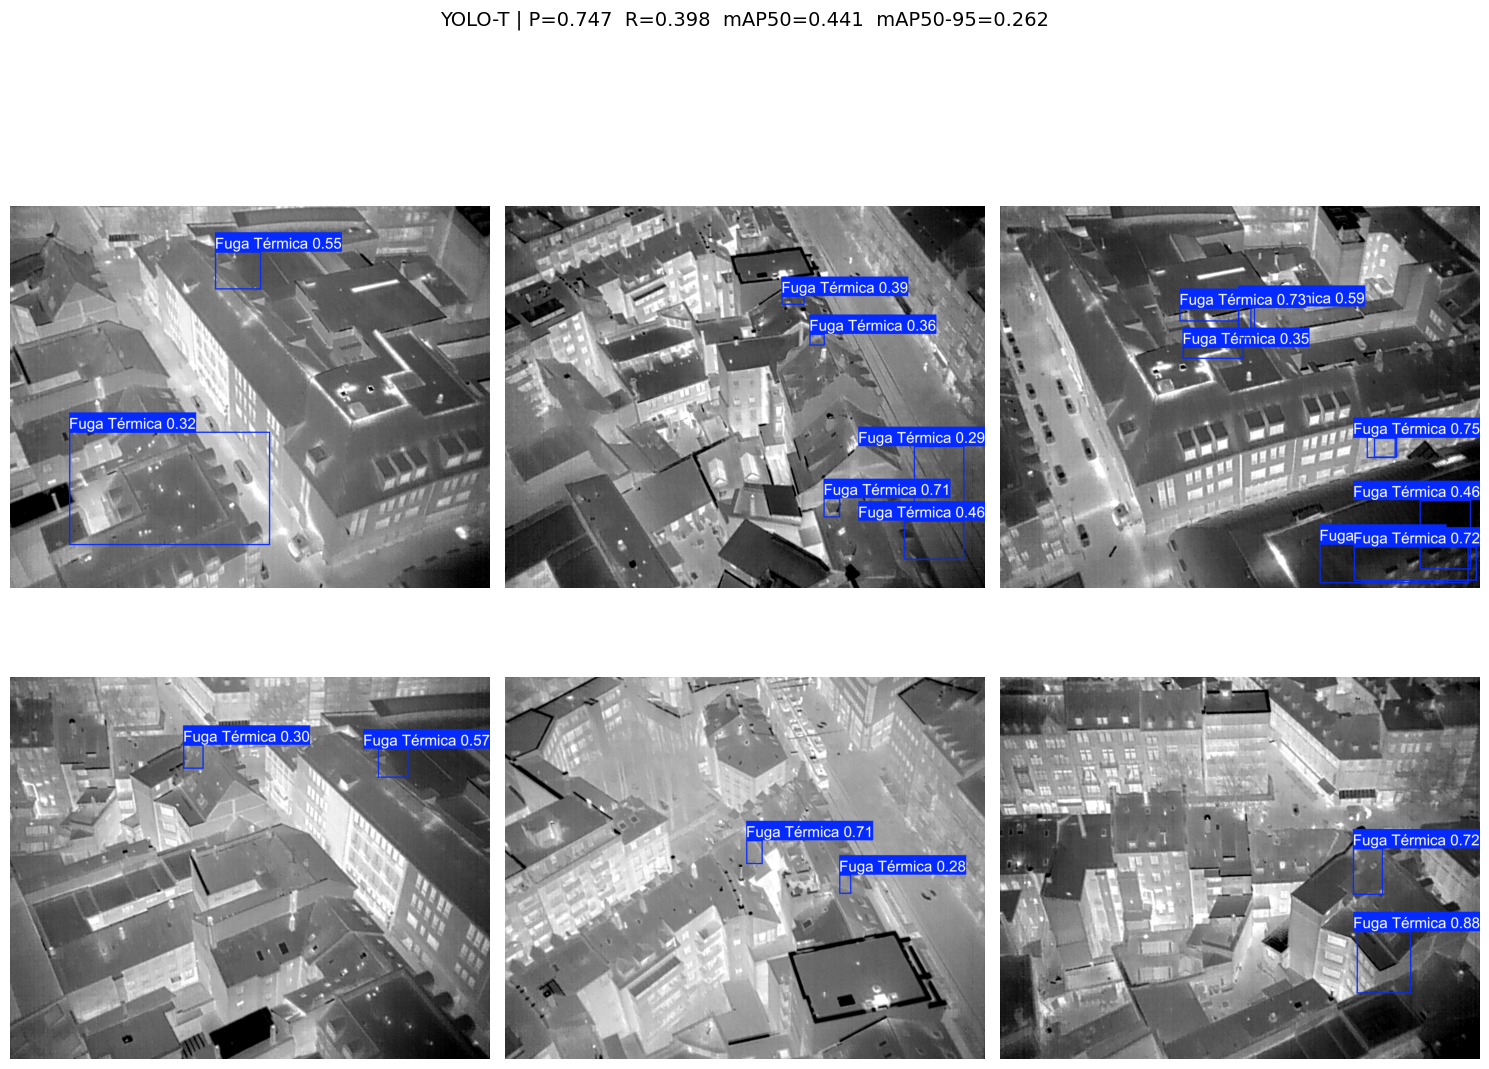

(-0.5, 2399.5, 1199.5, -0.5)

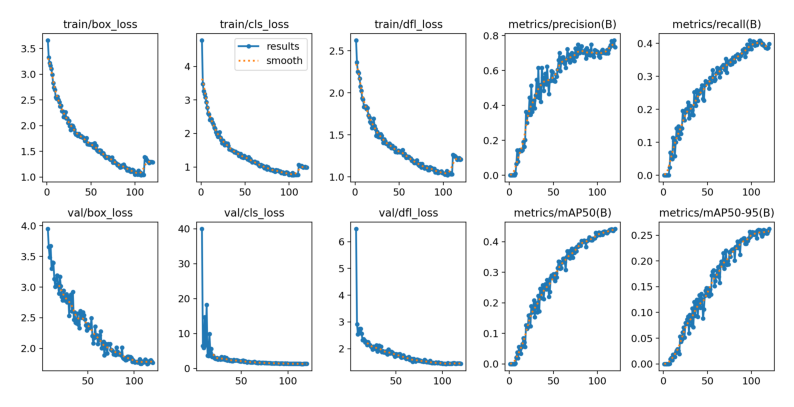

In [5]:

# ========= CONFIG =========
RUN_NAME   = "yolo_t"  # el mismo 'name=' que usaste en el train
RUNS_DIR   = Path("/home/ignacio/ProyectoFinalVA/runs")
BEST_WEIGHTS = RUNS_DIR / RUN_NAME / "weights" / "best.pt"
IMG_PATH = Path("/home/ignacio/ProyectoFinalVA/runs/yolo_t/results.png")

DATA_YAML = Path("/home/ignacio/ProyectoFinalVA/YOLO/T/YOLO_t.yaml")
DATA_ROOT = Path("/home/ignacio/ProyectoFinalVA/YOLO/T")
TEST_DIR  = DATA_ROOT / "images" / "test"

N_IMGS = 6
IMGSZ  = 640
CONF   = 0.25

model = YOLO(str(BEST_WEIGHTS))

# --------- 1) Métricas globales en val ---------
metrics = model.val(data=str(DATA_YAML))   # asegura usar tu YAML

mp    = metrics.box.mp
mr    = metrics.box.mr
map50 = metrics.box.map50
map95 = metrics.box.map

print("===== MÉTRICAS GLOBALES (VAL) =====")
print(f"Precision   (mp)      : {mp:.3f}")
print(f"Recall      (mr)      : {mr:.3f}")
print(f"mAP@0.5     (map50)   : {map50:.3f}")
print(f"mAP@0.5:0.95 (map)    : {map95:.3f}")
print("====================================")

# --------- 2) Predicciones sobre algunas imágenes de test ---------
test_paths = sorted(TEST_DIR.glob("*.png"))
if not test_paths:
    raise RuntimeError(f"No encontré PNGs en {TEST_DIR}")

sample = random.sample(test_paths, min(N_IMGS, len(test_paths)))

results = model.predict(
    source=[str(p) for p in sample],
    imgsz=IMGSZ,
    conf=CONF,
    save=False,
    verbose=False
)

cols = 3
rows = (len(results) + cols - 1) // cols
plt.figure(figsize=(5 * cols, 5 * rows + 2))

# Texto con métricas globales (arriba de todo)
plt.suptitle(
    f"YOLO-T | P={mp:.3f}  R={mr:.3f}  mAP50={map50:.3f}  mAP50-95={map95:.3f}",
    fontsize=14, y=0.98
)

for i, (p, r) in enumerate(zip(sample, results), start=1):
    plotted = r.plot()         # BGR
    plotted = plotted[..., ::-1]  # a RGB
    ax = plt.subplot(rows, cols, i)
    ax.imshow(plotted)
    ax.set_title(
        '', fontsize=9)
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.figure(figsize=(10,6))
plt.imshow(plt.imread(IMG_PATH)); plt.axis("off")



# Entrenamiento YOLO RGB

In [3]:
yaml_path = Path("/home/ignacio/ProyectoFinalVA/YOLO/RGB/YOLO_rgb.yaml")  # dataset completo
m = YOLO("yolo11x.pt")  

results = m.train(
    data=yaml_path,
    epochs=120,            # entrenamiento real (50–100 ideal)
    imgsz=640,            # resolución óptima para RGB
    batch=16,             # con GPU L4 va bien, si se llena la VRAM baja a 12 u 8
    device=0,             # GPU
    workers=4,
    amp=True,             # mixed precision (reduce VRAM y acelera)
    project="/home/ignacio/ProyectoFinalVA/runs",
    name="yolo_rgb",

    # 🔧 Estabilidad y augmentations
    rect=False,           # mejor para generalización
    cache="ram",          # acelera la segunda época en adelante
    patience=30,          # early stopping si no mejora
    hsv_h=0.0, hsv_s=0.2, hsv_v=0.2,  # leve jitter para rgb
    mosaic=0.8, mixup=0.0,            # buen balance sin artefactos
    flipud=0.0, fliplr=0.5,           # solo flip horizontal
    degrees=0.0, shear=0.0, translate=0.1, scale=0.5, perspective=0.0,

    # ⚙️ Optimizador y scheduler
    optimizer="auto",     
    cos_lr=True,          
)

print(results)


New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/home/ignacio/ProyectoFinalVA/YOLO/RGB/YOLO_rgb.yaml, epochs=120, time=None, patience=30, batch=16, imgsz=640, save=True, save_period=-1, cache=ram, device=0, workers=4, project=/home/ignacio/ProyectoFinalVA/runs, name=yolo_rgb, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, re

train: Scanning /home/ignacio/ProyectoFinalVA/YOLO/RGB/labels/train.cache... 325 images, 74 backgrounds, 0 corrupt: 100%|██████████| 399/399 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/RGB/images/train/DJI_0997_R.png: 10 duplicate labels removed


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.4GB RAM): 100%|██████████| 399/399 [00:39<00:00, 10.01it/s]
val: Scanning /home/ignacio/ProyectoFinalVA/YOLO/RGB/labels/val.cache... 111 images, 23 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/RGB/images/val/DJI_0995_R.png: 10 duplicate labels removed


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 134/134 [00:13<00:00,  9.98it/s]


Plotting labels to /home/ignacio/ProyectoFinalVA/runs/yolo_rgb/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /home/ignacio/ProyectoFinalVA/runs/yolo_rgb
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      16.8G      3.582      4.447      2.529        113        640: 100%|██████████| 25/25 [00:34<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]

                   all        134        810   0.000249     0.0123   0.000128   2.96e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      17.2G      3.138      3.468      2.219        110        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        134        810   0.000249     0.0123   0.000128   2.96e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      17.4G      3.059      3.136      2.103        183        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        134        810   0.000249     0.0123   0.000128   2.96e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      17.2G      2.947      2.923      2.059        145        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        134        810   0.000249     0.0123   0.000128   2.96e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      17.2G      2.866      2.798      2.013        139        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all        134        810   0.000667    0.00123   0.000338   3.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      17.4G      2.817      2.751      1.945        151        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

                   all        134        810   0.000323    0.00494   0.000107   4.28e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      17.4G      2.733      2.587       1.94         97        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        134        810   0.000323    0.00494   0.000107   4.28e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      17.4G      2.585      2.363      1.822        126        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]

                   all        134        810    0.00946    0.00864    0.00143   0.000453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      17.2G      2.533      2.381      1.795        137        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

                   all        134        810     0.0418     0.0494     0.0174    0.00545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      17.5G      2.455      2.231      1.726        134        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

                   all        134        810      0.115     0.0654     0.0303     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      17.4G      2.446      2.228      1.737        102        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

                   all        134        810      0.103     0.0617     0.0273    0.00917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      17.4G      2.424      2.202      1.713        137        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]

                   all        134        810      0.184     0.0914     0.0555     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      17.2G      2.362      2.123      1.695        134        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]

                   all        134        810      0.265     0.0741     0.0614     0.0204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      17.4G      2.284        2.1      1.682        107        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

                   all        134        810      0.126     0.0778     0.0342     0.0116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      17.4G      2.251      1.988      1.631        131        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        134        810      0.283      0.137     0.0991     0.0335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      17.4G      2.241      1.957      1.597        155        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        134        810      0.245       0.11     0.0713     0.0252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      17.2G      2.141      1.858      1.546        125        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]

                   all        134        810      0.302      0.115     0.0991     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      17.5G      2.148      1.867      1.559        109        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        134        810      0.343      0.143      0.125     0.0514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      17.4G      2.026       1.73        1.5        163        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.216      0.105     0.0594     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      17.4G      2.111        1.8      1.535        101        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        134        810      0.311      0.196      0.149      0.067



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      17.3G      2.128      1.854      1.589        167        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        134        810      0.338      0.175      0.139     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      17.4G      2.004      1.755      1.498        125        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        134        810      0.265     0.0938     0.0603     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      17.4G      2.015        1.7      1.474        102        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        134        810      0.301      0.168      0.131     0.0583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      17.4G      1.929      1.627      1.415        126        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        134        810      0.357      0.184      0.153     0.0692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      17.2G       1.95      1.599      1.445        152        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        134        810      0.256      0.179      0.133     0.0539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      17.5G      1.935      1.562      1.421         76        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        134        810      0.374       0.19      0.168     0.0669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      17.4G      1.867       1.57      1.418        116        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        134        810      0.369      0.207      0.175     0.0793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      17.4G      1.912       1.61       1.44         92        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        134        810      0.481       0.19      0.172     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      17.2G       1.82      1.494      1.401        143        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        134        810      0.404      0.219      0.175     0.0753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      17.4G      1.902      1.551      1.433        138        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        134        810       0.27       0.17      0.138     0.0629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      17.4G      1.835      1.494      1.386        134        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        134        810      0.381      0.185      0.164      0.072



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      17.4G      1.763      1.417      1.354        143        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        134        810      0.392      0.156      0.137     0.0516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      17.2G      1.784      1.439      1.403        122        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.427      0.217      0.205     0.0823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      17.4G      1.728      1.376      1.342        105        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        134        810       0.49      0.225      0.209     0.0909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      17.4G      1.731      1.382      1.344        134        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        134        810      0.463       0.22      0.191     0.0871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      17.5G      1.713      1.348       1.33        103        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.466      0.209      0.182     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      17.2G       1.74       1.36      1.327        120        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.493      0.242      0.219      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      17.4G      1.615      1.272      1.277        135        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.531       0.23       0.21     0.0925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      17.4G      1.729      1.392      1.343        128        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        134        810      0.405       0.23      0.209     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      17.4G      1.604      1.287      1.292        157        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.491      0.245      0.229        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      17.2G      1.691       1.32       1.29        119        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        134        810      0.419       0.26      0.232      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      17.5G       1.62      1.301       1.31        113        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        134        810      0.469      0.233        0.2     0.0885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      17.4G      1.614      1.214      1.296        142        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        134        810      0.509      0.237      0.237      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      17.4G      1.592      1.239      1.267        114        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.558      0.262       0.25      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      17.2G       1.66      1.295      1.275        149        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        134        810      0.304      0.211      0.169     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      17.4G      1.564      1.187      1.238        144        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.482      0.242      0.233      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      17.4G      1.563      1.171      1.233         94        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810       0.46      0.244      0.219      0.095



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      17.4G      1.524      1.171      1.226        160        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.564      0.258      0.257      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      17.2G      1.535      1.169      1.236        149        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        134        810      0.566       0.26      0.259      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      17.5G      1.542      1.184      1.258        109        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.626       0.28      0.302      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      17.4G      1.531      1.184      1.237         94        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        134        810      0.572      0.269      0.276      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      17.4G      1.511      1.143      1.226        110        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        134        810      0.573      0.309      0.298      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      17.2G      1.464      1.104      1.222        109        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.518      0.291      0.268       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      17.5G      1.491      1.152      1.233         91        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.559      0.241       0.25       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      17.4G      1.447      1.094      1.193        118        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.575      0.251      0.259      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      17.4G      1.508      1.125      1.218        109        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        134        810      0.542      0.272      0.278      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      17.2G      1.437      1.088        1.2        153        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        134        810      0.583      0.272      0.281      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      17.4G      1.415       1.05      1.175         85        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.548      0.279      0.274      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      17.4G       1.41      1.053      1.189        106        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810       0.62      0.295      0.294      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      17.4G      1.373      1.031      1.156        186        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.666      0.298      0.309      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      17.2G      1.369      1.028       1.17        125        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        134        810      0.593      0.268      0.285      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      17.4G      1.358          1      1.167        128        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.524      0.285      0.275      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      17.4G      1.394      1.019      1.165        128        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.595      0.293        0.3      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      17.4G      1.388      1.036      1.151        133        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.594      0.314       0.33      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      17.2G      1.348      1.002      1.149         96        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        134        810       0.54      0.235      0.238      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      17.4G      1.316      0.947       1.13         87        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        134        810      0.636      0.304       0.32      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      17.4G      1.294     0.9461      1.127        126        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

                   all        134        810      0.625      0.298      0.317      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      17.4G      1.332     0.9864      1.138        106        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.675      0.305      0.337      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      17.2G      1.347     0.9664      1.131        155        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        134        810      0.617       0.31      0.337      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      17.5G      1.309     0.9457      1.131        117        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.602      0.295      0.316      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      17.4G      1.274       0.93      1.111        161        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        134        810      0.523      0.337      0.326      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      17.4G      1.266     0.8954      1.105        135        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.642      0.327      0.345      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      17.2G      1.266     0.8965      1.094        127        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.658      0.312       0.35      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      17.5G      1.287     0.9182      1.112        147        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        134        810      0.521      0.295      0.298      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      17.4G      1.163     0.8366      1.061        153        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.515      0.325      0.328      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      17.4G      1.258     0.9214      1.121        127        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        134        810      0.711      0.312      0.375      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120      17.2G      1.217     0.8818      1.081        147        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.595      0.354      0.373       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      17.4G      1.225     0.8758      1.082        104        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.628        0.3      0.318       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      17.4G      1.187     0.8525      1.067        128        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

                   all        134        810      0.702      0.334       0.38      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      17.4G       1.14     0.8256      1.071         86        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.628      0.356      0.378      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      17.2G      1.165     0.8434      1.073        130        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        134        810      0.639      0.374      0.395      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      17.4G      1.135      0.811      1.056        153        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.678      0.319      0.359      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      17.4G      1.144     0.8185      1.058        136        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        134        810      0.596      0.363      0.374       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      17.4G      1.117     0.8052       1.05        120        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

                   all        134        810      0.684       0.34      0.387      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      17.2G      1.158     0.8449      1.081        127        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.596       0.32      0.336      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      17.5G       1.17     0.8326       1.06        144        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        134        810      0.739      0.305       0.36      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120      17.4G      1.153     0.8332      1.067         82        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.636      0.351      0.375      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      17.4G      1.097     0.7914      1.048        122        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.648      0.364       0.39      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      17.3G      1.116     0.8098      1.054        105        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.727      0.332      0.381      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      17.4G      1.117     0.8032      1.052        155        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.614      0.365      0.391      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120      17.4G      1.074     0.7703      1.021        107        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.617      0.352      0.384      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120      17.4G      1.081     0.7517      1.025         98        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.641      0.369      0.392      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      17.2G      1.076     0.7584      1.025        148        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.584      0.359      0.376      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120      17.4G      1.025     0.7278      1.004        139        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.613      0.351      0.371      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      17.4G      1.039     0.7421       1.02        115        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        134        810      0.644      0.375      0.395       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      17.4G      1.069     0.7591      1.024        100        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.601      0.377       0.39      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      17.2G      1.072     0.7683      1.021        139        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.671      0.356      0.399      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      17.4G      1.047     0.7594      1.026        101        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.629      0.351      0.376      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      17.4G      1.037     0.7401      1.019        118        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.635      0.374      0.384      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120      17.4G     0.9978     0.7188      1.017        181        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.644      0.381      0.397      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      17.2G      1.043     0.7386      1.019        143        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        134        810      0.627      0.368      0.391      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      17.4G      1.004     0.7154     0.9991        141        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.632      0.354      0.371      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      17.4G     0.9718      0.696      1.003        129        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810       0.62      0.359      0.371      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      17.4G      1.039     0.7466      1.035        131        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

                   all        134        810      0.633      0.365      0.385      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      17.2G     0.9965      0.698     0.9895        188        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.641      0.348       0.38      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      17.4G     0.9962     0.7166     0.9981        125        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        134        810      0.674      0.379      0.406      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      17.3G     0.9651     0.6899     0.9912        143        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        134        810      0.663       0.39      0.414      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      17.4G      1.005      0.716      1.011        115        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.641      0.381      0.415      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      17.2G     0.9728      0.701     0.9974        130        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.704      0.358      0.409      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      17.5G      0.979     0.7105      1.004        119        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

                   all        134        810      0.662      0.368      0.396      0.204


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120      17.4G      1.341      1.006      1.238         63        640: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810       0.65      0.369      0.396        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      17.4G      1.302     0.9832      1.208         82        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810       0.68       0.37      0.406      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      17.2G      1.254     0.9366      1.193         90        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        134        810      0.631      0.374      0.404      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      17.4G      1.242     0.9282      1.188         78        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810       0.62      0.383      0.401      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      17.4G      1.212     0.9437      1.172         71        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        134        810      0.659      0.367      0.398      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      17.4G      1.207     0.9136      1.164         75        640: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.686      0.381      0.413      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      17.2G      1.212     0.9229      1.169         75        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        134        810      0.656      0.379       0.41      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      17.4G      1.222     0.9342      1.185         76        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        134        810      0.653      0.386      0.412      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      17.4G      1.204     0.9147      1.157         86        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        134        810      0.654      0.395      0.415      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      17.4G      1.212     0.9113      1.167         76        640: 100%|██████████| 25/25 [00:18<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        134        810       0.67      0.391      0.418      0.208



120 epochs completed in 0.813 hours.
Optimizer stripped from /home/ignacio/ProyectoFinalVA/runs/yolo_rgb/weights/last.pt, 114.4MB
Optimizer stripped from /home/ignacio/ProyectoFinalVA/runs/yolo_rgb/weights/best.pt, 114.4MB

Validating /home/ignacio/ProyectoFinalVA/runs/yolo_rgb/weights/best.pt...
Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11x summary (fused): 464 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


                   all        134        810      0.667      0.391      0.417      0.217
Speed: 0.2ms preprocess, 11.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /home/ignacio/ProyectoFinalVA/runs/yolo_rgb
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f1bd42ba530>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031

# Predicciones YOLO RGB

In [3]:
trained = YOLO("/home/ignacio/ProyectoFinalVA/runs/yolo_rgb/weights/best.pt")

metrics = trained.val()
print(metrics)  

trained.predict(
    source="/home/ignacio/ProyectoFinalVA/YOLO/RGB/images/test",
    imgsz=416,
    conf=0.25,
    save=True,
    project="/home/ignacio/ProyectoFinalVA/runs",
    name="yolo_rgb_pred"
)


Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11x summary (fused): 464 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/ignacio/ProyectoFinalVA/YOLO/RGB/labels/val.cache... 111 images, 23 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/RGB/images/val/DJI_0995_R.png: 10 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


                   all        134        810       0.66      0.393      0.417      0.217
Speed: 1.7ms preprocess, 19.6ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/detect/val19
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f58b0381ae0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Fuga Térmica'}
 obb: None
 orig_img: array([[[139, 139, 143],
         [140, 140, 144],
         [144, 144, 148],
         ...,
         [102, 112,  63],
         [106, 111,  67],
         [131, 133,  93]],
 
        [[134, 135, 138],
         [134, 135, 138],
         [131, 131, 135],
         ...,
         [140, 149, 104],
         [161, 167, 125],
         [186, 191, 153]],
 
        [[131, 133, 134],
         [126, 128, 129],
         [116, 117, 120],
         ...,
         [181, 193, 148],
         [212, 221, 182],
         [224, 229, 192]],
 
        ...,
 
        [[ 29,  30,  22],
         [ 27,  27,  20],
         [ 24,  24,  17],
         ...,
         [ 94,  92,  71],
         [ 96,  90,  71],
         [ 85,  80,  63]],
 
        [[ 24,  24,  18],
         [ 18,  19,  12],
         [ 17,  17,  11],
         ...,
         [ 8

# Resultado YOLO RGB

Ultralytics 8.3.2 🚀 Python-3.10.17 torch-2.9.1+cu128 CUDA:0 (NVIDIA L4, 22478MiB)
YOLO11x summary (fused): 464 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


val: Scanning /home/ignacio/ProyectoFinalVA/YOLO/RGB/labels/val.cache... 111 images, 23 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/ignacio/ProyectoFinalVA/YOLO/RGB/images/val/DJI_0995_R.png: 10 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:14<00:00,  1.59s/it]


                   all        134        810       0.66      0.393      0.417      0.217
Speed: 1.5ms preprocess, 18.9ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/val20
===== MÉTRICAS GLOBALES (VAL) =====
Precision   (mp)      : 0.660
Recall      (mr)      : 0.393
mAP@0.5     (map50)   : 0.417
mAP@0.5:0.95 (map)    : 0.217


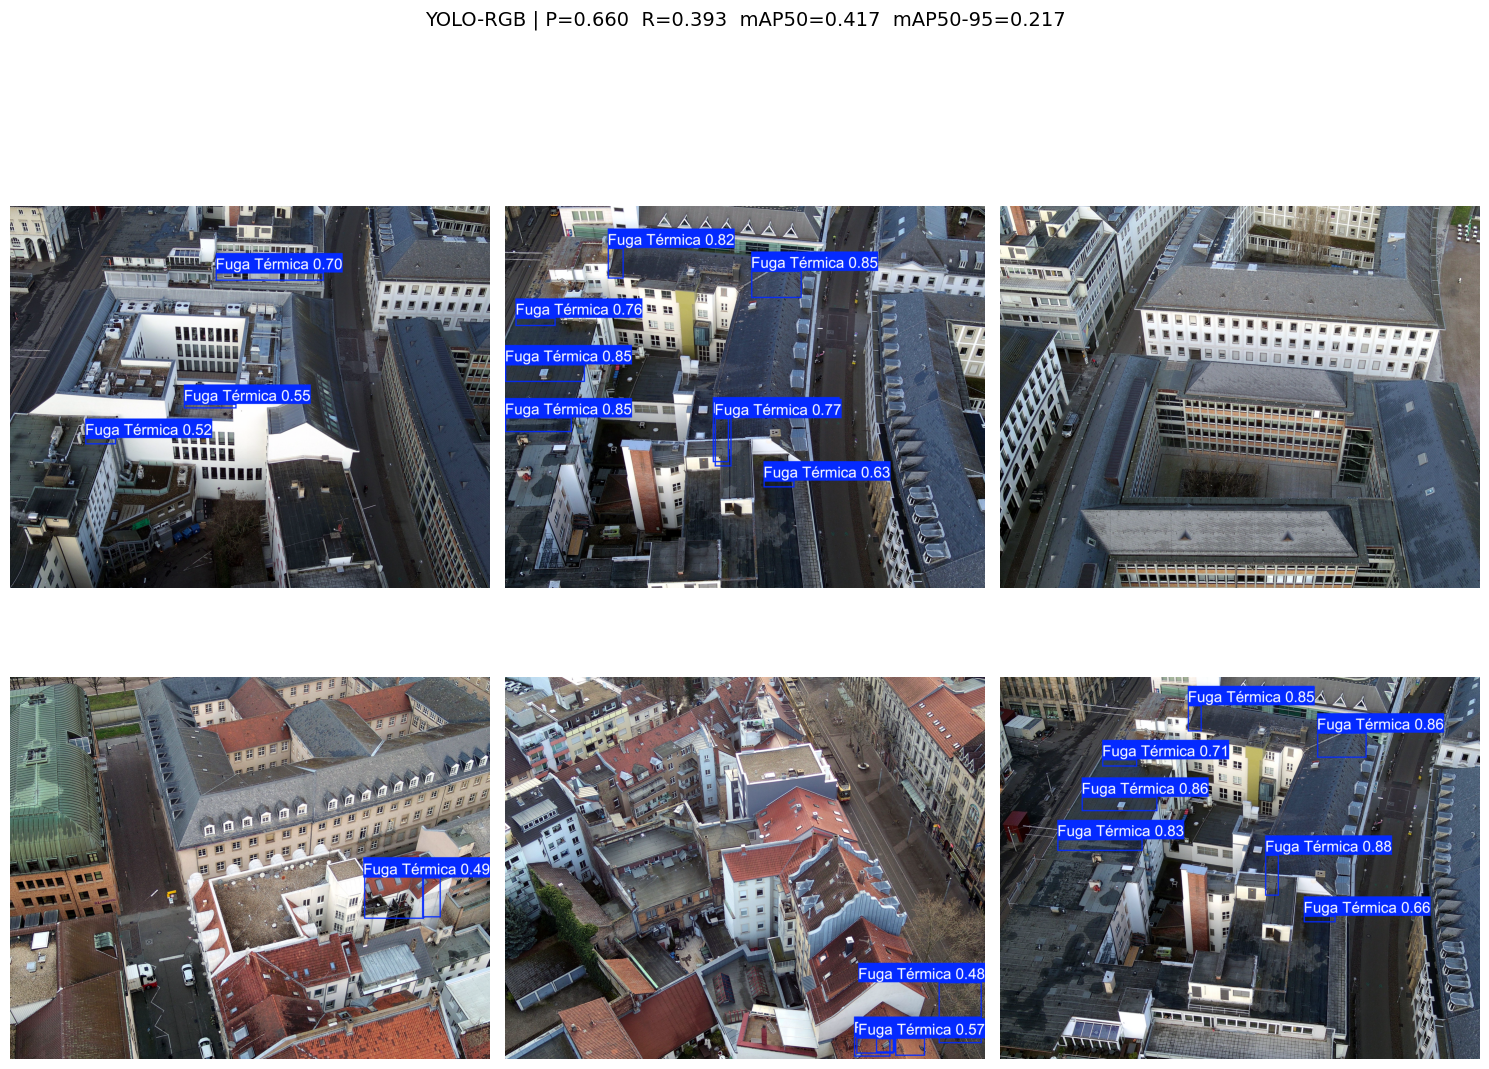

(-0.5, 2399.5, 1199.5, -0.5)

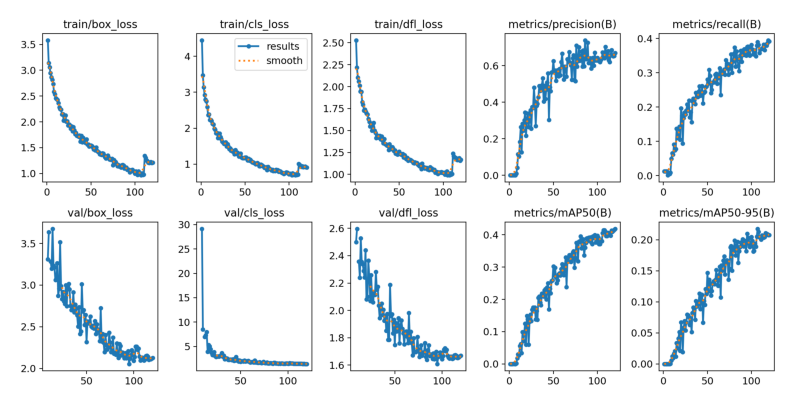

In [4]:

# ========= CONFIG =========
RUN_NAME   = "yolo_rgb"  # el mismo 'name=' que usaste en el train
RUNS_DIR   = Path("/home/ignacio/ProyectoFinalVA/runs")
BEST_WEIGHTS = RUNS_DIR / RUN_NAME / "weights" / "best.pt"
IMG_PATH = Path("/home/ignacio/ProyectoFinalVA/runs/yolo_rgb/results.png")

DATA_YAML = Path("/home/ignacio/ProyectoFinalVA/YOLO/RGB/YOLO_rgb.yaml")
DATA_ROOT = Path("/home/ignacio/ProyectoFinalVA/YOLO/RGB")
TEST_DIR  = DATA_ROOT / "images" / "test"

N_IMGS = 6
IMGSZ  = 640
CONF   = 0.25

model = YOLO(str(BEST_WEIGHTS))

# --------- 1) Métricas globales en val ---------
metrics = model.val(data=str(DATA_YAML))   # asegura usar tu YAML

mp    = metrics.box.mp
mr    = metrics.box.mr
map50 = metrics.box.map50
map95 = metrics.box.map

print("===== MÉTRICAS GLOBALES (VAL) =====")
print(f"Precision   (mp)      : {mp:.3f}")
print(f"Recall      (mr)      : {mr:.3f}")
print(f"mAP@0.5     (map50)   : {map50:.3f}")
print(f"mAP@0.5:0.95 (map)    : {map95:.3f}")
print("====================================")

# --------- 2) Predicciones sobre algunas imágenes de test ---------
test_paths = sorted(TEST_DIR.glob("*.png"))
if not test_paths:
    raise RuntimeError(f"No encontré PNGs en {TEST_DIR}")

sample = random.sample(test_paths, min(N_IMGS, len(test_paths)))

results = model.predict(
    source=[str(p) for p in sample],
    imgsz=IMGSZ,
    conf=CONF,
    save=False,
    verbose=False
)

cols = 3
rows = (len(results) + cols - 1) // cols
plt.figure(figsize=(5 * cols, 5 * rows + 2))

# Texto con métricas globales (arriba de todo)
plt.suptitle(
    f"YOLO-RGB | P={mp:.3f}  R={mr:.3f}  mAP50={map50:.3f}  mAP50-95={map95:.3f}",
    fontsize=14, y=0.98
)

for i, (p, r) in enumerate(zip(sample, results), start=1):
    plotted = r.plot()         # BGR
    plotted = plotted[..., ::-1]  # a RGB
    ax = plt.subplot(rows, cols, i)
    ax.imshow(plotted)
    ax.set_title(
        '', fontsize=9)
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.figure(figsize=(10,6))
plt.imshow(plt.imread(IMG_PATH)); plt.axis("off")



# Weighted boxes fusion